<a href="https://colab.research.google.com/github/vkrisvasan/GeminiAI_KV/blob/main/kv_fashion_buddy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install google-cloud-aiplatform ragstack-ai --upgrade


In [3]:
#python package for compression of data
#!pip install zlib-ng

In [4]:
import pandas as pd
import numpy as np
import getpass, os, requests, sys, json, vertexai
#import zlib

In [74]:
credential_names = ["GCP_PROJECT_ID", "ASTRA_DB_ENDPOINT", "ASTRA_DB_TOKEN","HF_TOKEN"]
for credential in credential_names:
  if credential not in os.environ:
    os.environ[credential]=getpass.getpass("Provide your..." + credential)
#print(os.environ["GCP_PROJECT_ID"])

In [75]:
from google.colab import userdata, auth, files, drive
from google.cloud import aiplatform
#print(os.environ["GCP_PROJECT_ID"])

!gcloud config set project {os.environ["GCP_PROJECT_ID"]}
auth.authenticate_user()


Updated property [core/project].


In [7]:
from datasets import load_dataset
dataset = load_dataset("vkrisvasan/zara_embedding",split='train')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [8]:
# How create embedding by creating a embedding model
from vertexai.preview.vision_models import MultiModalEmbeddingModel, Image
vertexai.init(project=os.getenv("GCP_PROJECT_ID"))

model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

#Generate and add the embeddings to the dataframe
def add_embeddings(df):
  for i in range(len(df)):
    if pd.isnull(df.loc[i, 'embeddings']).all():
      #Create Image from URL
      img_bytes = requests.get(df.loc[i, "product_imağes"]).content
      img = Image(img_bytes)
      # Create embedding based on Image
      cur_embeddings = model.get_embeddings(image= img,contextual_text = df.loc[i, 'product_name'])
      df.loc[i, 'embeddings'] = cur_embeddings.image_embedding

In [9]:
#add_embeddings(df)

In [10]:

#visualize embeddings
#print(df['embeddings'])

In [11]:
df = pd.DataFrame.from_dict(dataset)
df['embeddings']=df['embeddings'].apply(json.loads)

In [12]:
df.head()


,product_name,link,product_images,price,details,category,gender,embeddings
0,WORKOUT T-SHIRT,https://www.zara.com/in/en/workout-t-shirt-p05...,https://static.zara.net/photos///2023/I/0/2/p/...,32.06,T-shirt made of lightweight textured stretch f...,ACTIVEWEAR,men,"[0.00584839704, 0.00366304931, 0.0416106768, 0..."
1,SPORTS BACKPACK,https://www.zara.com/in/en/sports-backpack-p13...,https://static.zara.net/photos///2023/I/1/2/p/...,64.26,Multi-pocket backpack. Combination of material...,ACTIVEWEAR,men,"[0.00701390672, 0.00680825347, 0.0142998686, 0..."
2,COMPACT COTTON T-SHIRT,https://www.zara.com/in/en/compact-cotton-t-sh...,https://static.zara.net/photos///2023/I/0/2/p/...,32.06,Loose-fitting T-shirt made of compact cotton. ...,ACTIVEWEAR,men,"[0.0323305465, 0.0137906792, 0.0440658815, 0.0..."
3,TANK TOP WITH SLOGAN,https://www.zara.com/in/en/tank-top-with-sloga...,https://static.zara.net/photos///2023/I/0/2/p/...,27.86,Loose-fitting T-shirt made of cotton. Round ne...,ACTIVEWEAR,men,"[-0.0316199474, -0.0126086716, 0.036310371, 0...."
4,TRAINING SOCKS,https://www.zara.com/in/en/training-socks-p024...,https://static.zara.net/photos///2023/I/0/2/p/...,13.86,Pack of 2 pairs of seamless mesh socks with ri...,ACTIVEWEAR,men,"[0.0402002, -0.0139389914, 0.0203817375, 0.007..."


In [13]:
# Function to compress the embeddings without loosing / truncating the value
# {'errors': [{'message': "Document size limitation violated: number of elements an indexable Array (property 'embeddings') has (1408) exceeds maximum allowed (1000)", 'errorCode': 'SHRED_DOC_LIMIT_VIOLATION'}]}
"""
def compress_embeddings(embedding):
    compressed_embedding = zlib.compress(str(embedding).encode('utf-8'))
    return compressed_embedding

# Apply the function to the 'embeddings' column
df['embeddings'] = df['embeddings'].apply(compress_embeddings)


# Function to decompress the embeddings
def decompress_embeddings(compressed_embedding):
    decompressed_embedding = zlib.decompress(compressed_embedding).decode('utf-8')
    return eval(decompressed_embedding)

# Example usage: Decompress the embeddings in the first row
decompressed_embeddings = decompress_embeddings(df.loc[0, 'embeddings'])
print("Decompressed embeddings:")
print(decompressed_embeddings)

"""

'\ndef compress_embeddings(embedding):\n    compressed_embedding = zlib.compress(str(embedding).encode(\'utf-8\'))\n    return compressed_embedding\n\n# Apply the function to the \'embeddings\' column\ndf[\'embeddings\'] = df[\'embeddings\'].apply(compress_embeddings)\n\n\n# Function to decompress the embeddings\ndef decompress_embeddings(compressed_embedding):\n    decompressed_embedding = zlib.decompress(compressed_embedding).decode(\'utf-8\')\n    return eval(decompressed_embedding)\n\n# Example usage: Decompress the embeddings in the first row\ndecompressed_embeddings = decompress_embeddings(df.loc[0, \'embeddings\'])\nprint("Decompressed embeddings:")\nprint(decompressed_embeddings)\n\n'

In [14]:
# Define the maximum length
# to avoid error "{'errors': [{'message': "Document size limitation violated: number of elements an indexable Array (property 'embeddings') has (1408) exceeds maximum allowed (1000)", 'errorCode': 'SHRED_DOC_LIMIT_VIOLATION'}]}"
"""
max_length = 1000

# Function to truncate lists to the maximum length
def truncate_list(lst, max_length):
    return lst[:max_length]

# Apply the function to the 'embeddings' column
df['embeddings'] = df['embeddings'].apply(lambda x: truncate_list(x, max_length))
"""

"\nmax_length = 1000\n\n# Function to truncate lists to the maximum length\ndef truncate_list(lst, max_length):\n    return lst[:max_length]\n\n# Apply the function to the 'embeddings' column\ndf['embeddings'] = df['embeddings'].apply(lambda x: truncate_list(x, max_length))\n"

In [73]:
df.head()


,product_name,link,product_images,price,details,category,gender,embeddings
0,WORKOUT T-SHIRT,https://www.zara.com/in/en/workout-t-shirt-p05...,https://static.zara.net/photos///2023/I/0/2/p/...,32.06,T-shirt made of lightweight textured stretch f...,ACTIVEWEAR,men,"[0.00584839704, 0.00366304931, 0.0416106768, 0..."
1,SPORTS BACKPACK,https://www.zara.com/in/en/sports-backpack-p13...,https://static.zara.net/photos///2023/I/1/2/p/...,64.26,Multi-pocket backpack. Combination of material...,ACTIVEWEAR,men,"[0.00701390672, 0.00680825347, 0.0142998686, 0..."
2,COMPACT COTTON T-SHIRT,https://www.zara.com/in/en/compact-cotton-t-sh...,https://static.zara.net/photos///2023/I/0/2/p/...,32.06,Loose-fitting T-shirt made of compact cotton. ...,ACTIVEWEAR,men,"[0.0323305465, 0.0137906792, 0.0440658815, 0.0..."
3,TANK TOP WITH SLOGAN,https://www.zara.com/in/en/tank-top-with-sloga...,https://static.zara.net/photos///2023/I/0/2/p/...,27.86,Loose-fitting T-shirt made of cotton. Round ne...,ACTIVEWEAR,men,"[-0.0316199474, -0.0126086716, 0.036310371, 0...."
4,TRAINING SOCKS,https://www.zara.com/in/en/training-socks-p024...,https://static.zara.net/photos///2023/I/0/2/p/...,13.86,Pack of 2 pairs of seamless mesh socks with ri...,ACTIVEWEAR,men,"[0.0402002, -0.0139389914, 0.0203817375, 0.007..."


In [31]:
from astrapy.db import AstraDB, AstraDBCollection

astra_db = AstraDB(token=os.getenv("ASTRA_DB_TOKEN"),api_endpoint=os.getenv("ASTRA_DB_ENDPOINT"))

In [76]:
#SET THE correct Dimension based on the embedding model output to avoid error "SHRED_DOC_LIMIT_VIOLATION"
collection = astra_db.create_collection(collection_name="fashion_buddy_workshop2",dimension=1408,metric="cosine")
#print(f"* Collection: {collection.full_name}\n")

In [19]:
#

In [20]:
#Create embeddings

In [77]:
from ipywidgets import IntProgress
from IPython.display import display

def load_to_astra(df, collection,dflength):
  #len_df=len(df)
  len_df=dflength
  print(len_df)
  f=IntProgress(min=0,max=len_df)
  display(f)
  for i in range(len_df):
    f.value += 1
    f.description = str(f.value) + "/" + str(len_df)

    product_name=df.loc[i,"product_name"]
    link = df.loc[i,"link"]
    product_images = df.loc[i,"product_images"]
    price = df.loc[i,"price"]
    details = df.loc[i,"details"]
    category = df.loc[i,"category"]
    gender = df.loc[i,"gender"]
    embeddings = df.loc[i,"embeddings"]

    try:
      collection.insert_one({
          "_id":i,
          "product_name":product_name,
          "link":link,
         "product_images":product_images,
          "price":price,
          "details":details,
          "category":category,
          "gender": gender,
          "$vector": embeddings}) #Keep column name as $Vector to avoid SHRED_DOC_LIMIT_VIOLATION error
    except Exception as error:
      error_info = json.loads(str(error))
      print(error_info)


In [42]:
len_df=len(df)
print(len_df)

936


In [43]:
#load_to_astra(df,collection)
dflength = len_df
load_to_astra(df,collection,dflength)


936


IntProgress(value=0, max=936)

In [78]:
#Takes an image (URL or image file) and returns it
def get_image(image_source):
  if image_source.startswith("http://") or image_source.startswith("https://"):
    img_bytes = requests.get(image_source).content
    img = Image(img_bytes)
    return img
  else:
    img = Image.load_from_file(image_source)
    return img

#Gets image embeddings using Google Gemini model
def get_img_embeddings(img, text=""):
  embeddings = model.get_embeddings(image=img,
                                    contextual_text=text # passes text along with the image (multimodal)
  )
  return embeddings.image_embedding

#Displays recommendations by category returned by Astra Vector Search
def show_recommendations(documents, category=None):
  if category:
    print()
    print("Category:", category)
  for doc in documents:
    print(doc["product_name"], "$" + str(doc["price"]), ", Gender:", doc["gender"])
    print(doc["details"])
    print(doc["link"])
    print("Similarity score: ", doc["$similarity"])

#Finds the similar itens of the given reference image and categories (if any) aleng with a search prompt to give t
def find_similar_items(reference_image, categories=None):
  reference_img = get_image(reference_image)
  print("Reference image:")
  reference_img.show()
  print("Selected Categories:", ", ".join(categories) if categories else "None")
  if categories:
    for category in categories:
      # Run multiple ANN searches to pull top 3 matches
      # for each category requested
      search_prompt= """
      I am trying to find pieces of apparel that are similar to what is in thIS picture.
      Ignore the-model and only focus on finding the most similar clothing.

      I only care about apparel that falls within the category contained within triple backticks:
      '''{category}'''
      """.format(category=category)
      reference_embeddings = get_img_embeddings(reference_img, text=search_prompt)
      #Run an ANN search filtering by apparel category
      documents = collection.vector_find(reference_embeddings,limit=3,filter={"category": category},include_similarity="True")
      show_recommendations(documents, category=category)
  else:
    search_prompt = """
      I am trying to find pieces of apparel that are similar to what is in this picture.
      Pretend as if there is no model in the image, only clothing.
      """

    reference_embeddings = get_img_embeddings(reference_img, text=search_prompt)
    #print(reference_embeddings)
    #Run single ANN search across entire DB
    documents = collection.vector_find(reference_embeddings,limit=3)
    #print(documents)
    show_recommendations(documents)


In [52]:
from google.colab import files
uploaded = files.upload()

Saving zara_workout1.jpeg to zara_workout1.jpeg


In [53]:
reference_image = "/content/sample_image1.jpeg"

reference_image = "/content/zaratrouser1.jpeg"
reference_image = "/content/zara_shirt1.jpeg"
reference_image = "/content/zara_workout1.jpeg"


Reference image:


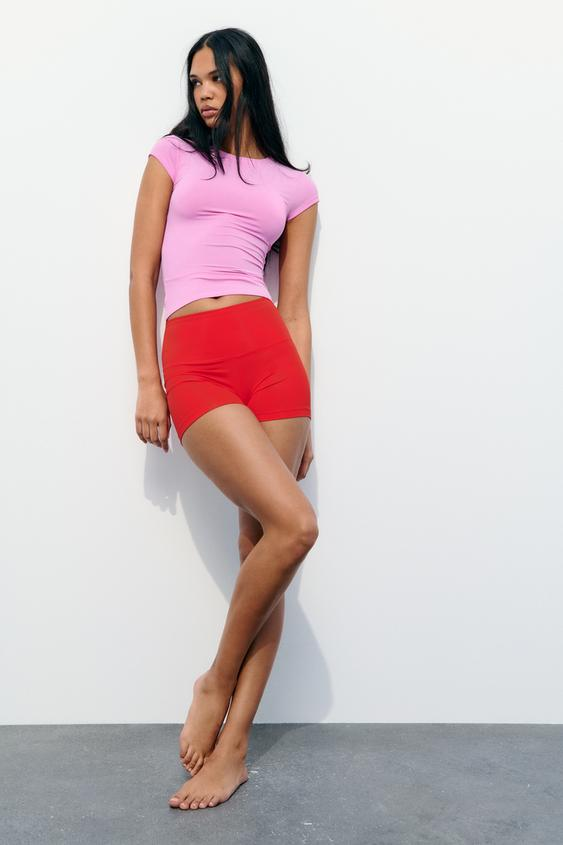

Selected Categories: None
DENIM TRF PLAYSUIT $69.86 , Gender: women
Sleeveless denim playsuit with a lapel collar. Patch pockets on the chest and back. Front pockets. Frayed hems. Front zip fly and metal button fastening.
https://www.zara.com/in/en/denim-trf-playsuit-p08197187.html
Similarity score:  0.7434805
FITTED KNIT DRESS WITH OPEN BACK $32.06 , Gender: women
Short dress with a round neckline, short sleeves and an open-back detail.
https://www.zara.com/in/en/fitted-knit-dress-with-open-back-p05584634.html
Similarity score:  0.7360153
PRINTED TULLE ASYMMETRIC DRESS $46.06 , Gender: women
Short dress with an asymmetric neckline. Draped fabric. Lining. Invisible zip fastening.
https://www.zara.com/in/en/printed-tulle-asymmetric-dress-p07930432.html
Similarity score:  0.7288269


In [72]:
find_similar_items(reference_image)

In [79]:
#print(get_img_embeddings(get_image("/content/zaratrouser1.jpeg"),""))